# Greybox Fuzzing

The first version of [American Fuzzy Lop](http://lcamtuf.coredump.cx/afl/) (AFL) was released on November 2013. Since then, AFL has become one of the most successful fuzzing tools and comes in many flavours, e.g., [AFLFast](https://github.com/mboehme/aflfast), [AFLGo](https://github.com/aflgo/aflgo), and [AFLSmart](https://github.com/aflsmart/aflsmart). AFL has made fuzzing a popular choice for automated vulnerability detection. It was the first to demonstrate that vulnerabilities can be detected automatically at a large scale in many security-critical, real-world applications.

![American Fuzzy Lop Command Line User Interface](http://lcamtuf.coredump.cx/afl/afl_screen.png)
<center><b>Figure 1.</b> American Fuzzy Lop Command Line User Interface</center>

In this chapter, we are going to expand on what we have learned in the chapter on [Mutation-based Fuzzing](MutationFuzzer.ipynb). We will explore the greybox fuzzing algorithm behind AFL and how we can exploit it to solve various problems for automated vulnerability detection.

**Prerequisites**
* [Fuzzing: Breaking Things with Random Inputs](Fuzzer.ipynb)
* [Mutation-based Fuzzing](MutationFuzzer.ipynb)

We'll have a few refreshers on these topics throughout this chapter. So, don't worry if you don't satisfy the prerequisits.

## Ingredients for Greybox Fuzzing

### Background
AFL is a *mutation-based fuzzer*. Meaning, AFL generates new inputs by slightly modifying a seed input (i.e., mutation), or by joining the first half of one input with the second half of another (i.e., splicing).

AFL is also *greybox fuzzer* (not blackbox nor whitebox). Meaning, AFL leverages coverage-feedback to learn how to reach deeper into the program. It is not entirely blackbox because AFL leverages at least *some* program analysis. It is not entirely whitebox either because AFL does not build on heavyweight program analysis or constraint solving. Instead, AFL uses lightweight program instrumentation to glean some information about the (branch) coverage of a generated input.
If a generated input increases coverage, it is added to the seed corpus for further fuzzing.

To instrument a program, AFL injects a piece of code right after every conditional jump instruction. When executed, this so-called trampoline assigns the exercised branch a unique identifier and increments a counter that is associated with this branch. For efficiency, only a coarse branch hit count is maintained. In other words, for each input the fuzzer knows which branches and roughly how often they are exercised. 
The instrumentation is usually done at compile-time, i.e., when the program source code is compiled to an executable binary. However, it is possible to run AFL on uninstrumented binaries using tools such as a virtual machine (e.g., [QEMU](https://github.com/mirrorer/afl/blob/master/qemu_mode)) or a dynamic instrumentation tool (e.g., [Intel PinTool](https://github.com/vanhauser-thc/afl-pin)). For Python programs, we can collect coverage information without any instrumentation (see chapter on [collecting coverage](Coverage.ipynb#Coverage-of-Basic-Fuzzing)).

### Mutator and Seed

In [1]:
import random
import fuzzingbook_utils
from Coverage import Coverage, population_coverage

First, we'll introduce the Mutator class. Given a seed input *inp*, the mutator returns a slightly modified version of *inp*. Later, we extend this class to consider the input grammar for smart greybox fuzzing.

In [2]:
class Mutator(object):
    
    def __init__(self):
        self.mutators = [
            self.delete_random_character,
            self.insert_random_character,
            self.flip_random_character
        ]
    
    def delete_random_character(self,s):
        """Returns s with a random character deleted"""
        if s == "":
            return self.insert_random_character(s)

        pos = random.randint(0, len(s) - 1)
        return s[:pos] + s[pos + 1:]

    def insert_random_character(self,s):
        """Returns s with a random character inserted"""
        pos = random.randint(0, len(s))
        random_character = chr(random.randrange(32, 127))
        return s[:pos] + random_character + s[pos:]

    def flip_random_character(self,s):
        """Returns s with a random bit flipped in a random position"""
        if s == "":
            return self.insert_random_character(s)

        pos = random.randint(0, len(s) - 1)
        c = s[pos]
        bit = 1 << random.randint(0, 6)
        new_c = chr(ord(c) ^ bit)
        return s[:pos] + new_c + s[pos + 1:]
        
    def mutate(self, inp):
        """Return s with a random mutation applied"""
        mutator = random.choice(self.mutators)
        return mutator(inp)

Let's try the mutator. You can actually interact with such a "cell" and try other inputs by loading this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

In [3]:
Mutator().mutate("good")

'cood'

Now we introduce a new concept; the power schedule. A power schedule distributes the precious fuzzing time among the seeds in the population. Our objective is to maximize the time spent fuzzing those (most progressive) seeds which lead to higher coverage increase in shorter time.

We call the likelihood with which a seed is chosen from the population as the seed's *energy*. Throughout a fuzzing campaign, we would like to prioritize seeds that are more promising. Simply said, we do not want to waste energy fuzzing non-progressive seeds. We call the procedure that decides a seed's energy as the fuzzer's *power schedule*. For instance, AFL's schedule assigns more energy to seeds that are shorter, that execute faster, and yield coverage increases more often.

First, there is some information that we need to attach to each seed in addition to the seed's data. Hence, we define the following `Seed` class.

In [4]:
class Seed(object):
    
    def __init__(self, data):
        """Set seed data"""
        self.data = data
        
    def __str__(self):
        """Returns data as string representation of the seed"""
        return self.data
    __repr__ = __str__

### Power Schedule
The power schedule that is implemented below assigns each seed the same energy. Once a seed is in the population, it will be fuzzed as often as any other seed in the population.

In Python, we can can squeeze long for-loops into much smaller statements.
* `lambda x: ...` returns a function that takes `x` as input. Lambda allows for quick definitions unnamed functions.
* `map(f, l)` returns a list where the function `f` is applied to each element in list `l`.
* `np.random.choice(l,p)` returns element `l[i]` with probability in `p[i]`.

In [5]:
import numpy as np

In [6]:
class PowerSchedule(object):
    
    def assignEnergy(self, population):
        """Assigns each seed the same energy"""
        for seed in population:
            seed.energy = 1

    def normalizedEnergy(self, population):
        """Normalize energy"""
        energy = list(map(lambda seed: seed.energy, population))
        sum_energy = sum(energy)  # Add up all values in energy
        norm_energy = list(map(lambda nrg: nrg/sum_energy, energy))
        return norm_energy
    
    def choose(self, population):
        """Choose weighted by normalized energy."""
        self.assignEnergy(population)
        norm_energy = self.normalizedEnergy(population)
        seed = np.random.choice(population, p=norm_energy)
        return seed

Let's see whether this power schedule chooses seeds uniformly at random. We ask the schedule 10k times to choose a seed from the population of three seeds (A, B, C) and keep track of the number of times we have seen each seed. We should see each seed about 3.3k times.

In [7]:
population = [Seed("A"), Seed("B"), Seed("C")]
schedule = PowerSchedule()
hits = {
    "A" : 0,
    "B" : 0,
    "C" : 0
}

for i in range(10000):
    seed = schedule.choose(population)
    hits[seed.data] += 1

hits

{'A': 3379, 'B': 3320, 'C': 3301}

Looks good. Every seed has been chosen about a third of the time.

### Runner and Sample Program
We'll start with a small sample program of six lines. In order to collect coverage information during execution, we import the `FunctionCoverageRunner` class from the chapter on [mutation-based fuzzing](MutationFuzzer.ipynb#Guiding-by-Coverage). 

The `FunctionCoverageRunner` constructor takes a Python `function` to execute. The function `run` takes an input, passes it on to the Python `function`, and collects the coverage information for this execution. The function `coverage()` returns a list of tuples `(function name, line number)` for each statement that has been covered in the Python `function`.

In [8]:
from MutationFuzzer import FunctionCoverageRunner

The `crashme` function raises an exception for the input "bad!". Let's see which statements are covered for the input "good".

In [9]:
def crashme (s):
    if             len(s) > 0 and s[0] == 'b':
        if         len(s) > 1 and s[1] == 'a':
            if     len(s) > 2 and s[2] == 'd':
                if len(s) > 3 and s[3] == '!':
                    raise Exception()

crashme_runner = FunctionCoverageRunner(crashme)
crashme_runner.run("good")
list(crashme_runner.coverage())

[('run_function', 7), ('crashme', 2), ('__exit__', 25)]

In `crashme`, the input "good" only covers the if-statement in line 2. The branch condition `len(s) > 0 and s[0] == 'b'` evaluates to False. 

## AFLFast: Fuzzer Boosting

### Blackbox Mutation-based Fuzzer
Let's integrate both the mutator and power schedule into a fuzzer. We'll start with a blackbox fuzzer -- which does *not* leverage any coverage information. 

Our `MutationFuzzer` class inherits from the [Fuzzer](Fuzzer.ipynb#Fuzzer-Classes) class. For now, we only need to know the functions `fuzz` which returns a generated input and `runs` which executes `fuzz` a specified number of times. For our `MutationFuzzer` class, we override the function `fuzz`.

In [10]:
from Fuzzer import Fuzzer

The `MutationFuzzer` is constructed with a set of initial seeds, a mutator, and a power schedule. Throughout the fuzzing campaign, it maintains a seed corpus called `population`. The function `fuzz` returns either an unfuzzed seed from the initial seeds, or the result of fuzzing a seed in the population. The function `create_candidate` handles the latter. It randomly chooses an input from the population and applies a number of mutations.

In [11]:
class MutationFuzzer(Fuzzer):
    
    def __init__(self, seeds, mutator, schedule):
        self.seeds = seeds
        self.mutator = mutator
        self.schedule = schedule
        self.inputs = []
        self.reset()

    def reset(self):
        """Reset the initial population and seed index"""
        self.population = list(map(lambda x: Seed(x), self.seeds))
        self.seed_index = 0

    def create_candidate(self):
        """Returns an input generated by fuzzing a seed in the population"""
        seed = self.schedule.choose(self.population)

        # Stacking: Apply multiple mutations to generate the candidate
        candidate = seed.data
        trials = min(len(candidate), 1 << random.randint(1,5))
        for i in range(trials):
            candidate = self.mutator.mutate(candidate)
        return candidate

    def fuzz(self):
        """Returns first each seed once and then generates new inputs"""
        if self.seed_index < len(self.seeds):
            # Still seeding
            self.inp = self.seeds[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
            
        self.inputs.append(self.inp)
        return self.inp
    

Okay, let's take the mutation fuzzer for a spin. Given a single seed, we ask it to generate three inputs.

In [12]:
seed_input = "good"
mutation_fuzzer = MutationFuzzer([seed_input], Mutator(), PowerSchedule())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())

good
ooD
cW(ond


Let's see how many statements the mutation-based blackbox fuzzer covers in a campaign with n=30k inputs.

The fuzzer function `runs(crashme_runner, trials=n)` generates `n` inputs and executes them on the `crashme` function via the `crashme_runner`. As stated earlier, the `crashme_runner` also collects coverage information.

In [13]:
import time
n = 30000

In [14]:
blackbox_fuzzer = MutationFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
blackbox_fuzzer.runs(crashme_runner, trials=n)
end = time.time()

"It took the blackbox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the blackbox mutation-based fuzzer 3.72 seconds to generate and execute 30000 inputs.'

In order to measure coverage, we import the [population_coverage](Coverage.ipynb#Coverage-of-Basic-Fuzzing) function. It takes a set of inputs and a Python function, executes the inputs on that function and collects coverage information. Specifically, it returns a tuple `(all_coverage, cumulative_coverage)` where `all_coverage` is the set of statements covered by all inputs, and `cumulative_coverage` is the number of statements covered as the number of executed inputs increases. We are just interested in the latter to plot coverage over time.

In [15]:
from Coverage import population_coverage

We extract the generated inputs from the blackbox fuzzer and measure coverage as the number of inputs increases.

In [16]:
_, blackbox_coverage = population_coverage(blackbox_fuzzer.inputs, crashme)
bb_max_coverage = max(blackbox_coverage)

"The blackbox mutation-based fuzzer achieved a maximum coverage of %d statements." % bb_max_coverage

'The blackbox mutation-based fuzzer achieved a maximum coverage of 3 statements.'

The following generated inputs increased the coverage for our `crashme` [example](#Runner-and-Sample-Program).

In [17]:
[seed_input] + \
[blackbox_fuzzer.inputs[idx] for idx in range(len(blackbox_coverage)) 
    if blackbox_coverage[idx] > blackbox_coverage[idx - 1]
]

['good', 'bgod']

***Summary***. This is how a blackbox mutation-based fuzzer works. We have integrated the *mutator* to generate inputs by fuzzing a provided set of initial seeds and the *power schedule* to decide which seed to choose next.

### Greybox Mutation-based Fuzzer
In contrast to a blackbox fuzzer, a greybox fuzzer *does* leverage coverage information. Specifically, a greybox fuzzer adds to the seed population generated inputs which increase code coverage.

The function `run` is inherited from the [Fuzzer](Fuzzer.ipynb#Fuzzer-Classes) class. It is called to generate and execute exactly one input. We override this function to add an input to the `population` that increases coverage. The greybox fuzzer attribute `coverage_seen` maintains the set of statements, that have previously been covered.

In [18]:
class GreyboxFuzzer(MutationFuzzer):
    
    def reset(self):
        """Reset the initial population, seed index, coverage information"""
        super().reset()
        self.coverages_seen = set()
        self.population = [] # population is filled during greybox fuzzing
           
    def run(self, runner):
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            # We have new coverage
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

Let's take our greybox fuzzer for a spin.

In [19]:
seed_input = "good"
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
greybox_fuzzer.runs(crashme_runner, trials=n)
end = time.time()

"It took the greybox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the greybox mutation-based fuzzer 3.55 seconds to generate and execute 30000 inputs.'

Does the greybox fuzzer cover more statements after generating the same number of test inputs?

In [20]:
_, greybox_coverage = population_coverage(greybox_fuzzer.inputs, crashme)
gb_max_coverage = max(greybox_coverage)

"Our greybox mutation-based fuzzer covers %d more statements" % (gb_max_coverage - bb_max_coverage)

'Our greybox mutation-based fuzzer covers 3 more statements'

Our seed population for our [example](#Runner-and-Sample-Program) now contains the following seeds.

In [21]:
greybox_fuzzer.population

[good, bood, bakndZ, badb, bad!b]

Coverage-feedback is indeed helpful. The new seeds are like bread crumbs or milestones that guide the fuzzer to progress more quickly into deeper code regions. Following is a simple plot showing the coverage achieved over time for both fuzzers on our simple [example](#Runner-and-Sample-Program).

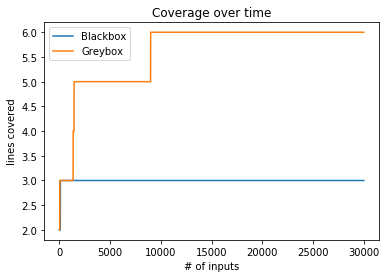

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt

line_bb, = plt.plot(blackbox_coverage, label="Blackbox")
line_gb, = plt.plot(greybox_coverage, label="Greybox")
plt.legend(handles=[line_bb, line_gb])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')
plt.show()

***Summary***. We have seen how a greybox fuzzer "discovers" interesting seeds that can lead to more progress. From the input `good`, our greybox fuzzer has slowly learned how to generate the input `bad!` which raises the exception. Now, how can we do that even faster?

***Try it***. How much coverage would be achieved over time using a blackbox *generation-based* fuzzer? Try plotting the coverage for all three fuzzers. You can define the blackbox generation-based fuzzer as follows.
```Python
from Fuzzer import RandomFuzzer
blackbox_gen_fuzzer = RandomFuzzer(min_length=4, max_length=4, char_start=32, char_range=96)
```
You can execute your own code by opening this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

### Boosted Greybox Fuzzer
Our boosted greybox fuzzer assigns more energy to seeds that promise to achieve more coverage. We change the power schedule such that seeds that exercise "unusual" paths have more energy. With *unusual paths*, we mean paths that are not exercised very often by generated inputs.

In order to identify which path is exercised by an input, we leverage the function `getPathID` from the section on [trace coverage](WhenIsEnough.ipynb#Trace-Coverage).

In [23]:
import pickle  # serializes an object by producing a byte array from all the information in the object
import hashlib # produces a 128-bit hash value from a byte array

The function `getPathID` returns a unique hash for a coverage set.

In [24]:
def getPathID(coverage):
    """Returns a unique hash for the covered statements"""
    pickled = pickle.dumps(coverage)
    return hashlib.md5(pickled).hexdigest()

There are several ways to assign energy based on how unusual the exercised path is. In this case, we implement an exponential power schedule which computes the energy $e(s)$ for a seed $s$ as follows
$$e(s) = \frac{1}{f(p(s))^a}$$
where 
* $p(s)$ returns the ID of the path exercised by $s$, 
* $f(p)$ returns the number of times the path $p$ is exercised by generated inputs, and 
* $a$ is a given exponent.

In [25]:
class AFLFastSchedule(PowerSchedule):
    
    def __init__(self, exponent):
        self.exponent = exponent
            
    def assignEnergy(self, population):
        """Assign exponential energy inversely proportional to path frequency"""
        for seed in population:
            seed.energy = 1 / (self.path_frequency[getPathID(seed.coverage)] ** self.exponent)

In the greybox fuzzer, lets keep track of the number of times $f(p)$ each path $p$ is exercised, and update the power schedule.

In [26]:
class CountingGreyboxFuzzer(GreyboxFuzzer):

    def reset(self):
        """Reset path frequency"""
        super().reset()
        self.schedule.path_frequency = {}
    
    def run(self, runner):
        """Inform scheduler about path frequency"""
        result, outcome = super().run(runner)

        path_id = getPathID(runner.coverage())
        if not path_id in self.schedule.path_frequency:
            self.schedule.path_frequency[path_id] = 1
        else:
            self.schedule.path_frequency[path_id] += 1
            
        return(result, outcome)

Okay, lets run our boosted greybox fuzzer $n=10k$ times on our simple [example](#Runner-and-Sample-Program). We set the exponentent of our exponential power schedule to $a=5$.

In [27]:
n=10000
seed_input = "good"
fast_schedule = AFLFastSchedule(5)
fast_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), fast_schedule)
start = time.time()
fast_fuzzer.runs(crashme_runner, trials=n)
end = time.time()

"It took the fuzzer w/ exponential schedule %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer w/ exponential schedule 1.28 seconds to generate and execute 10000 inputs.'

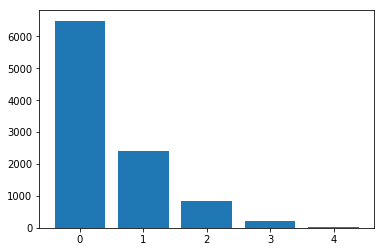

             path id 'p'           : path frequency 'f(p)'


{'1dbb8f48864b678bcbfa7d65b6f5ea03': 6492,
 '2af0d3cc199ee27acfdb4f2b5c3d2e69': 2418,
 'd4218925202cca7bbe5fbf6bf3be06e1': 827,
 '60aa4eb17ee216fe9665dfc19fdff6a8': 226,
 '9bbd34e56225c5106d087e16269a54e2': 37}

In [28]:
x_axis = np.arange(len(fast_schedule.path_frequency))
y_axis = list(fast_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
#plt.yscale("log")
#plt.yticks([10,100,1000,10000])
plt.show()

print("             path id 'p'           : path frequency 'f(p)'")
fast_schedule.path_frequency

How does it compare to our greybox fuzzer with the classical power schedule?

In [29]:
seed_input = "good"
orig_schedule = PowerSchedule()
orig_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), orig_schedule)
start = time.time()
orig_fuzzer.runs(crashme_runner, trials=n)
end = time.time()

"It took the fuzzer w/ original schedule %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer w/ original schedule 1.04 seconds to generate and execute 10000 inputs.'

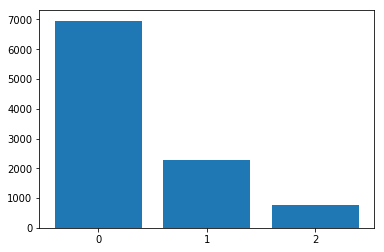

             path id 'p'           : path frequency 'f(p)'


{'1dbb8f48864b678bcbfa7d65b6f5ea03': 6958,
 '2af0d3cc199ee27acfdb4f2b5c3d2e69': 2272,
 'd4218925202cca7bbe5fbf6bf3be06e1': 770}

In [30]:
x_axis = np.arange(len(orig_schedule.path_frequency))
y_axis = list(orig_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
#plt.yscale("log")
#plt.yticks([10,100,1000,10000])
plt.show()

print("             path id 'p'           : path frequency 'f(p)'")
orig_schedule.path_frequency

The exponential power schedule shaves some of the executions of the "high-frequency path" off and adds them to the lower-frequency paths. The path executed least often is either not at all exercised using the traditional power schedule or it is exercised much less often.

Let's have a look at the energy that is assigned to the discovered seeds.

In [31]:
orig_energy = orig_schedule.normalizedEnergy(orig_fuzzer.population)

for (seed, norm_energy) in zip(orig_fuzzer.population, orig_energy):
    print("'%s', %0.5f, %s" % (getPathID(seed.coverage), norm_energy, seed.data))

'1dbb8f48864b678bcbfa7d65b6f5ea03', 0.33333, good
'2af0d3cc199ee27acfdb4f2b5c3d2e69', 0.33333, bo;ot
'd4218925202cca7bbe5fbf6bf3be06e1', 0.33333, ba9olt


In [32]:
fast_energy = fast_schedule.normalizedEnergy(fast_fuzzer.population)

for (seed, norm_energy) in zip(fast_fuzzer.population, fast_energy):
    print("'%s', %0.5f, %s" % (getPathID(seed.coverage), norm_energy, seed.data))

'1dbb8f48864b678bcbfa7d65b6f5ea03', 0.00000, good
'2af0d3cc199ee27acfdb4f2b5c3d2e69', 0.00000, bood
'd4218925202cca7bbe5fbf6bf3be06e1', 0.00000, bapd
'60aa4eb17ee216fe9665dfc19fdff6a8', 0.00012, bad
'9bbd34e56225c5106d087e16269a54e2', 0.99988, bad!


Exactly. Our new exponential power schedule assigns most energy to the seed exercising the lowest-frequency path.

Let's compare them in terms of coverage achieved over time for our simple [example](#Runner-and-Sample-Program).

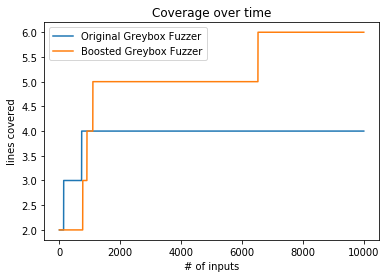

In [33]:
_, orig_coverage = population_coverage(orig_fuzzer.inputs, crashme)
_, fast_coverage = population_coverage(fast_fuzzer.inputs, crashme)
line_orig, = plt.plot(orig_coverage, label="Original Greybox Fuzzer")
line_fast, = plt.plot(fast_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_orig, line_fast])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')
plt.show()

As expected, the boosted greybox fuzzer (with the exponential power schedule) achieves coverage much faster.

***Summary***. By fuzzing seeds more often that exercises low-frequency paths, we can explore program paths in a much more efficient manner.

***Try it***. You can try other exponents for the fast power schedule, or change the power shedule entirely. Note that a large exponent can lead to overflows and imprecisions in the floating point arithmetic producing unexpected results. You can execute your own code by opening this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

***Read***. You can find out more about fuzzer boosting in the paper "[Coverage-based Greybox Fuzzing as Markov Chain](https://mboehme.github.io/paper/CCS16.pdf)" and check out the implementation into AFL at [http://github.com/mboehme/aflfast].

### Complex Example: XMLParser
Let's compare the three fuzzers on a more realistic example, the Python [HTML parser](https://docs.python.org/3/library/html.parser.html). We run all three fuzzers $n=5k$ times on the HTMLParser, starting with the "empty" seed.

In [34]:
from html.parser import HTMLParser
import traceback

In [35]:
# create wrapper function
def my_parser(inp):
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

n = 5000
seed_input = " " # empty seed
parser_runner = FunctionCoverageRunner(my_parser)
blackbox_fuzzer = MutationFuzzer([seed_input], Mutator(), PowerSchedule())
greybox_fuzzer  = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())
boosted_fuzzer  = CountingGreyboxFuzzer([seed_input], Mutator(), AFLFastSchedule(5))

In [36]:
start = time.time()
blackbox_fuzzer.runs(parser_runner, trials=n)
greybox_fuzzer.runs(parser_runner, trials=n)
boosted_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took all three fuzzers %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took all three fuzzers 17.28 seconds to generate and execute 5000 inputs.'

How do the fuzzers compare in terms of coverage over time?

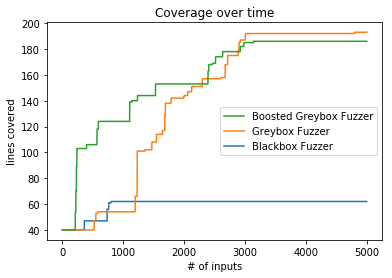

In [37]:
_, black_coverage = population_coverage(blackbox_fuzzer.inputs, my_parser)
_, grey_coverage = population_coverage(greybox_fuzzer.inputs, my_parser)
_, boost_coverage = population_coverage(boosted_fuzzer.inputs, my_parser)
line_black, = plt.plot(black_coverage, label="Blackbox Fuzzer")
line_grey, = plt.plot(grey_coverage, label="Greybox Fuzzer")
line_boost, = plt.plot(boost_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_boost, line_grey, line_black])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')
plt.show()

Both greybox fuzzers clearly outperform the greybox fuzzer. The reason is that the greybox fuzzer "discovers" interesting inputs along the way. Let's have a look at the last 10 inputs generated by the greybox versus blackbox fuzzer.

In [38]:
blackbox_fuzzer.inputs[-10:]

[' j', 'j ', '$', '0', '', '', '"', '> ', '', '']

In [39]:
greybox_fuzzer.inputs[-10:]

['CCE(<B4$`/0.:Iam<rc+~',
 'Pm&*</d\x15gWB\x15>\x1cM+`<_TO3@{ZI`=:r',
 "\x18AK;z&V%'<=)/@=<C7]\x02&+oD5/>{I.]",
 "c\x18</\x18p<'=yo`?`6M@}}Jcqx;",
 '&MA+z5 u.',
 '\x02\x18<?d(8>]=<GoaQ=>&m<"} Bi:',
 '$\x18#Q<8<g]%Gog5&mARZ=4R\x02];',
 'R\x18z&I#<d/(=<c!/$f\x0c5>{M<T `]9:',
 'R<<d/d(=oc,\x17>\\{<VX}9:t',
 'R\x18z[$#4d/-(=<gocB$\x0c5>{!M}<T2]']

The greybox fuzzer executes much more complicated inputs, many of which include special characters such as opening and closing brackets and chevrons (i.e., `<, >, [, ]`). Yet, many important keywords, such as `<html>` are still missing. How can we inform the fuzzer about these important keywords?

***Try it***. You can re-run these experiments to understand the variance of fuzzing experiments. Sometimes, the fuzzer that we claim to be superior does not seem to outperform the inferior fuzzer. In order to execute your own code, you just need to open this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

## AFLSmart: Smart Greybox Fuzzing
\todo{Reference [Fuzzing with Input Fragments](LangFuzzer.ipynb)}

### Dictionary: Injecting Important Keywords
Today, dictionaries are the main mechanism to inform a greybox fuzzer about important keywords in the input.

\todo{}

In [40]:
class DictMutator(Mutator):
    def __init__(self, dictionary):
        super().__init__()
        self.dictionary = dictionary
        self.mutators.append(self.insert_from_dictionary)
        
    def insert_from_dictionary(self,s):
        """Returns s with a keyword from the dictionary inserted"""
        pos = random.randint(0, len(s))
        random_keyword = random.choice(self.dictionary)
        return s[:pos] + random_keyword + s[pos:]

In [41]:
n=2500
html_dict = ["<a>","</a>","<a/>", "='a'"]
dict_fuzzer = CountingGreyboxFuzzer([seed_input], DictMutator(html_dict), AFLFastSchedule(5))
start = time.time()
dict_fuzzer.runs(parser_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 54.39 seconds to generate and execute 2500 inputs.'

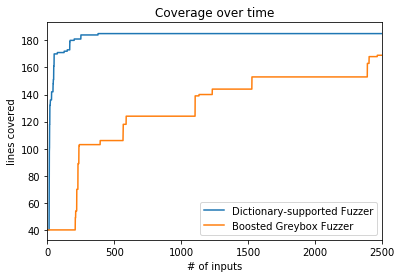

In [42]:
_, dict_coverage = population_coverage(dict_fuzzer.inputs, my_parser)
line_dict, = plt.plot(dict_coverage, label="Dictionary-supported Fuzzer")
line_boost, = plt.plot(boost_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_dict, line_boost])
plt.xlim(0,n)
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered')
plt.show()

### Structural Mutation of Valid Seeds
\todo{Recall [Grammar-based Mutational Fuzzing](LangFuzzer.ipynb)}

### Structural Mutation of Invalid Seeds
\todo{partial parsing, degree of validity}

### Putting it all Together
\todo{integration with low-level mutations and dictionary, deferred parsing}

\todo{Reference [AFLSmart](https://github.com/aflsmart/aflsmart) and "[Smart Greybox Fuzzing](https://arxiv.org/abs/1811.09447)"}

## AFLGo: Directed Greybox Fuzzing
Sometimes, you just want the fuzzer to reach some dangerous location in the source code. This could be a location, where you expect a buffer overflow. Or you want to test a recent change in your code base. How do we direct the fuzzer towards these locations?

In this chapter, we introduce directed greybox fuzzing as an optimization problem.

### Solving the Maze
To provide a meaningful example where you can easily change the code complexity and target location, we generate the maze source code from the maze provided as string. This example is loosly based on an old [blog post](https://feliam.wordpress.com/2010/10/07/the-symbolic-maze/) on symbolic execution by Felipe Andres Manzano (Quick shout-out!).

You simply specify the maze as a string. Like so.

In [43]:
maze_string = """
+-+-----+
|X|     |
| | --+ |
| |   | |
| +-- | |
|     |#|
+-----+-+
"""

The code is generated using the function `generate_maze_code`. We'll hide the implementation and instead explain what it does. If you are interested in the coding, go [here](ControlFlow.ipynb#Example:-Maze).

In [44]:
from ControlFlow import generate_maze_code

In [45]:
maze_code = generate_maze_code(maze_string)
exec(maze_code)

The objective is to get the "X" to the "#" by providing inputs `D` for down, `U` for up, `L` for left, and `R` for right.

In [46]:
print(maze("DDDDRRRRUULLUURRRRDDDD")) # Appending one more 'D', you have reached the target.

SOLVED

+-+-----+
| |     |
| | --+ |
| |   | |
| +-- | |
|     |X|
+-----+-+



Each character in `maze_string` represents a tile. For each tile, a tile-function is generated. 
* If the current tile is "benign" (` `), the tile-function corresponding to the next input character (D, U, L, R) is called. Unexpected input characters are ignored. If no more input characters are left, it returns "VALID" and the current maze state.
* If the current tile is a "trap" (`+`,`|`,`-`), it returns "INVALID" and the current maze state.
* If the current tile is the "target" (`#`), it returns "SOLVED" and the current maze state.

***Try it***. You can test other sequences of input characters, or even change the maze entirely. In order to execute your own code, you just need to open this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

To get an idea of the generated code, lets look at the static [call graph](https://en.wikipedia.org/wiki/Call_graph). A call graph shows the order in which functions can be executed.

In [47]:
from ControlFlow import print_callgraph

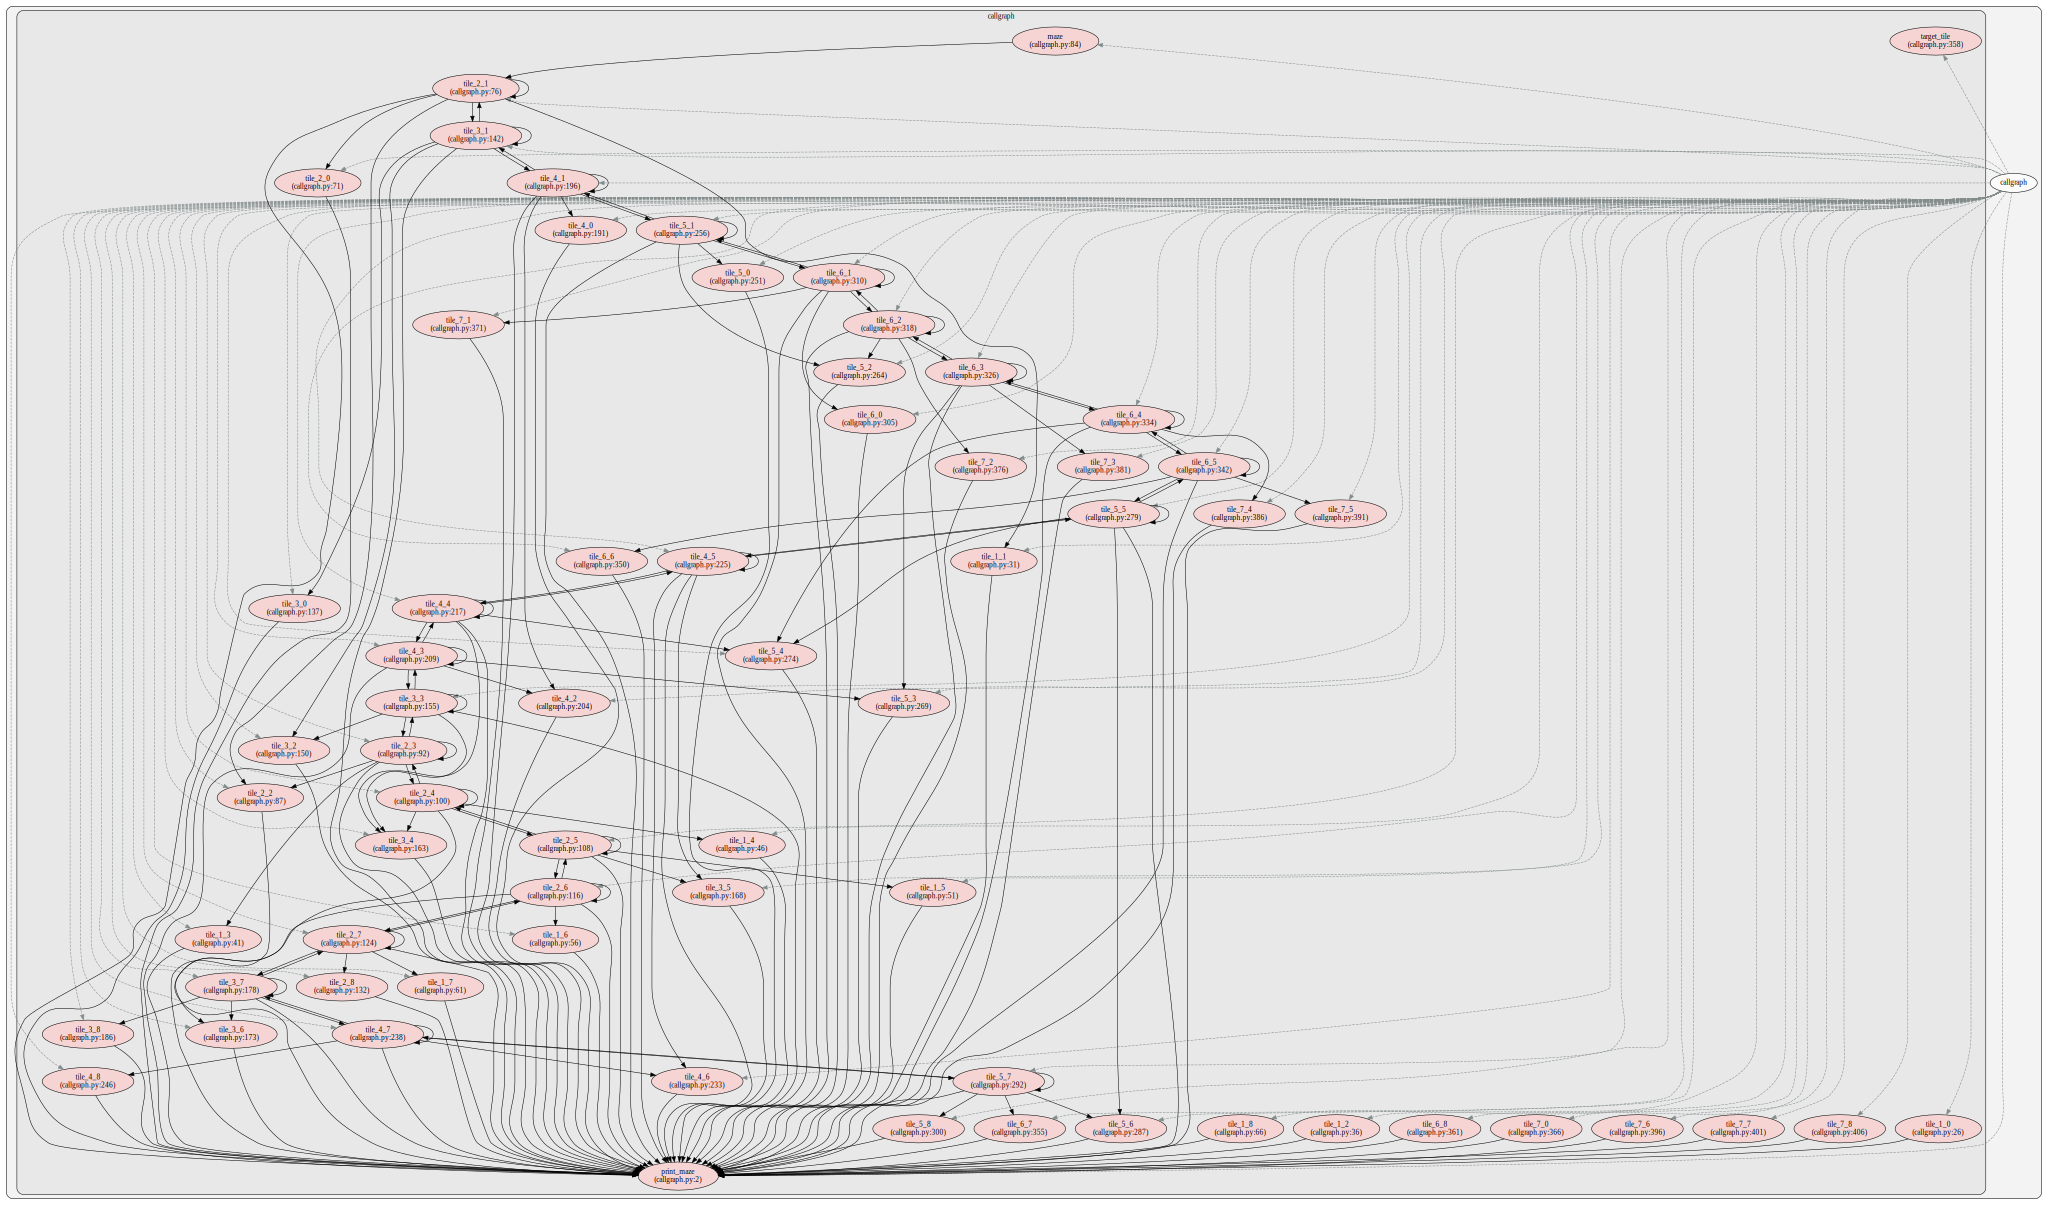

In [48]:
print_callgraph(maze_code)

### A First Attempt
To fuzz the maze, we extend the [DictMutator](Greybox_Fuzzing.ipynb#Dictionary:-Injecting-Important-Keywords) class to append dictionary keywords to the end of the seed and to remove a character from the end of the seed.

In [49]:
class MazeMutator(DictMutator):
    def __init__(self, dictionary):
        super().__init__(dictionary)
        self.mutators.append(self.delete_last_character)
        self.mutators.append(self.append_from_dictionary)

    def append_from_dictionary(self,s):
        """Returns s with a keyword from the dictionary appended"""
        random_keyword = random.choice(self.dictionary)
        return s + random_keyword
    
    def delete_last_character(self,s):
        """Returns s without the last character"""
        if (len(s) > 0):
            return s[:-1]

Let's try a standard greybox fuzzer with the classic power schedule and our extended maze mutator (n=10k).

In [50]:
n = 10000
seed_input = " " # empty seed

maze_runner = FunctionCoverageRunner(maze)
maze_mutator = MazeMutator(["L","R","U","D"])
maze_schedule = PowerSchedule()
maze_fuzzer  = GreyboxFuzzer([seed_input], maze_mutator, maze_schedule)

start = time.time()
maze_fuzzer.runs(maze_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 13.93 seconds to generate and execute 10000 inputs.'

We will need to print statistics for several fuzzers. Why don't we define a function for that?

In [51]:
def print_stats(fuzzer):
    total = len(fuzzer.population)
    solved = 0
    invalid = 0
    valid = 0
    for seed in fuzzer.population:
        s = maze(str(seed.data))
        if "INVALID" in s: invalid += 1
        elif "VALID" in s: valid += 1
        elif "SOLVED" in s: 
            solved += 1
            if solved == 1: print("First solution: %s" % seed)
        else: print("??")

    print("""Out of %d seeds, 
* %4d solved the maze, 
* %4d were valid but did not solve the maze, and 
* %4d were invalid""" % (total, solved, valid, invalid))   

How well does our good, old greybox fuzzer do?

In [52]:
print_stats(maze_fuzzer)

Out of 870 seeds, 
*    0 solved the maze, 
*  210 were valid but did not solve the maze, and 
*  660 were invalid


It probably didn't solve the maze a single time. How can we make the fuzzer aware how "far" a seed is from reaching the target? If we know that, we can just assign more energy to that seed.

***Try it***. Print the statistics for the boosted fuzzer using the `AFLFastSchedule` and the `CountingGreyboxFuzzer`. It will likely perform much better than the unboosted greybox fuzzer: The lowest-probablity path happens to be also the path which reaches the target. You can execute your own code by opening this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb) 

### Computing Function-Level Distance
Using the static call graph for the maze code and the target function, we can compute the distance of each function $f$ to the target $t$ as the length of the shortest path between $f$ and $t$.

Fortunately, the generated maze code includes a function called `target_tile` which returns the name of the target-function.

In [53]:
target = target_tile()
target

'tile_6_7'

Now, we need to find the corresponding function in the call graph. The function `get_callgraph` returns the call graph for the maze code as [networkx](https://networkx.github.io/) graph. Networkx provides some useful functions for graph analysis.

In [54]:
import networkx as nx
from ControlFlow import get_callgraph

In [55]:
CG = get_callgraph(maze_code)
for node in CG.nodes():
    if target in node:
        target_node = node
        break
target_node

'callgraphX__tile_6_7'

We can now generate the function-level distance. The dictionary `distance` contains for each function the distance to the target-function.  If there is no path to the target, we assign a maximum distance (`0xFFFF`).

The function `nx.shortest_path_length(CG, node, target_node)` returns the length of the shortest path from function `node` to function `target_node` in the call graph `CG`.

In [56]:
distance = {}
for node in CG.nodes():
    if "__" in node: 
        name = node.split("__")[-1]
    else: 
        name = node
    try:
        distance[name] = nx.shortest_path_length(CG, node, target_node)
    except:
        distance[name] = 0xFFFF

These are the distance values for all tile-functions on the path to the target function.

In [57]:
{k: distance[k] for k in list(distance) if distance[k] < 0xFFFF}

{'callgraphX': 1,
 'tile_4_1': 20,
 'tile_5_5': 13,
 'tile_4_3': 10,
 'tile_4_4': 11,
 'tile_5_7': 1,
 'tile_3_1': 21,
 'tile_4_5': 12,
 'tile_4_7': 2,
 'tile_6_1': 18,
 'tile_3_3': 9,
 'tile_2_1': 22,
 'tile_6_2': 17,
 'maze': 23,
 'tile_6_3': 16,
 'tile_6_4': 15,
 'tile_2_3': 8,
 'tile_5_1': 19,
 'tile_6_5': 14,
 'tile_2_4': 7,
 'tile_3_7': 3,
 'tile_2_5': 6,
 'tile_2_6': 5,
 'tile_6_7': 0,
 'tile_2_7': 4}

***Summary***. Using the static call graph and the target function $t$, we have shown how to compute the function-level distance of each function $f$ to the target $t$.

***Try it***. You can try and execute your own code by opening this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb) 
* How do we compute distance if there are multiple targets? (Hint: [Geometric Mean](https://en.wikipedia.org/wiki/Geometric_mean)).
* Given the call graph (CG) and the control-flow graph (CFG$_f$) for each function $f$, how do we compute basic-block (BB)-level distance? (Hint: In CFG$_f$, measure the BB-level distance to *calls* of functions on the path to the target function. Remember that BB-level distance in functions with higher function-level distance is higher, too.)

***Read***. If you are interested in other aspects of search, you can follow up by reading the chapter on [Search-based Fuzzing](SearchBasedFuzzer.ipynb). If you are interested, how to solve the problems above, you can have a look at our paper on "[Directed Greybox Fuzzing](https://mboehme.github.io/paper/CCS17.pdf)".

### Directed Power Schedule
Now that we know how to compute the function-level distance, let's try to implement a power schedule that assigns *more energy to seeds with a lower average distance* to the target function. Notice that the distance values are all *pre-computed*. These values are injected into program binary, just like the coverage instrumentation. In practice, this makes the computation of the average distance *extremely efficient*.

If you really want to know. Given the function-level distance $d_f(s,t)$ of a function $s$ to a function $t$ in call graph $CG$, our directed power schedule computes the seed distance $d(i,t)$ for a seed $i$ to function $t$ as $d(i,t)=\sum_{s\in CG}\dfrac{d_f(s,t)}{|CG|}$ where $|CG|$ is the number of nodes in the call graph $CG$.

In [58]:
class DirectedSchedule(PowerSchedule):
    def __init__(self, distance, exponent):
        self.distance = distance
        self.exponent = exponent

    def __getFunctions__(self, coverage):
        functions = set()
        for f, _ in set(coverage):
            functions.add(f)
        return functions
    
    def assignEnergy(self, population):
        """Assigns each seed energy inversely proportional
           to the average function-level distance to target."""
        for seed in population:
            if not hasattr(seed, 'distance'):
                num_dist = 0
                sum_dist = 0
                for f in self.__getFunctions__(seed.coverage):
                    if f in list(distance):
                        sum_dist += distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist
                seed.energy = (1 / seed.distance) ** self.exponent

Let's see how the directed schedule performs against the good, old greybox fuzzer.

In [59]:
directed_schedule = DirectedSchedule(distance, 3)
directed_fuzzer  = GreyboxFuzzer([seed_input], maze_mutator, directed_schedule)

start = time.time()
directed_fuzzer.runs(maze_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 21.85 seconds to generate and execute 10000 inputs.'

In [60]:
print_stats(directed_fuzzer)

Out of 1421 seeds, 
*    0 solved the maze, 
*  483 were valid but did not solve the maze, and 
*  938 were invalid


It probably didn't solve a single maze either, but we have more valid solutions. So, there is definitely progress.

Let's have a look at the distance values for each seed.

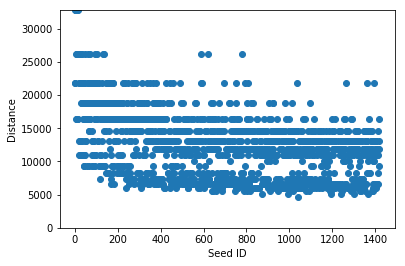

In [61]:
y = [seed.distance for seed in directed_fuzzer.population]
x = range(len(y))
plt.scatter(x, y)
plt.ylim(0,max(y))
plt.xlabel("Seed ID")
plt.ylabel("Distance")
plt.show()

Let's normalize the y-axis and improve the importance of the small distance seeds.

### Improved Directed Power Schedule
The improved directed schedule normalizes seed distance between the minimal and maximal distance.
Again, if you really want to know. Given the seed distance $d(i,t)$ of a seed $i$ to a function $t$, our improved power schedule computes the new seed distance $d'(i,t)$ as 
$$
d'(i,t)=\begin{cases}
1 & \text{if } d(i,t) = \text{minD} = \text{maxD}\\
\text{maxD} - \text{minD} & \text{if } d(i,t) = \text{minD} \neq \text{maxD}\\
\frac{d(i,t)-\text{minD}}{\text{maxD} - \text{minD}} & \text{otherwise}
\end{cases}
$$
where 
$$\text{minD}=\min_{i\in T}[d(i,t)]$$
and
$$\text{maxD}=\max_{i\in T}[d(i,t)]$$
where $T$ is the set of seeds (i.e., the population).

In [62]:
class AFLGoSchedule(DirectedSchedule):
    def assignEnergy(self, population):
        """Assigns each seed energy inversely proportional
           to the average function-level distance to target."""
        min_dist = 0xFFFF
        max_dist = 0
        for seed in population:
            if not hasattr(seed, 'distance'):
                num_dist = 0
                sum_dist = 0
                for f in self.__getFunctions__(seed.coverage):
                    if f in list(distance):
                        sum_dist += distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist
            if seed.distance < min_dist: min_dist = seed.distance
            if seed.distance > max_dist: max_dist = seed.distance

        for seed in population:
            if (seed.distance == min_dist):
                if min_dist == max_dist:
                    seed.energy = 1
                else: 
                    seed.energy = max_dist - min_dist
            else:
                seed.energy = ((max_dist - min_dist) / (seed.distance - min_dist)) 

Let's see how the improved power schedule performs.

In [63]:
aflgo_schedule = AFLGoSchedule(distance, 3)
aflgo_fuzzer  = GreyboxFuzzer([seed_input], maze_mutator, aflgo_schedule)

start = time.time()
aflgo_fuzzer.runs(maze_runner, trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 33.37 seconds to generate and execute 10000 inputs.'

In [64]:
print_stats(aflgo_fuzzer)

First solution: ;D1(EIDEbDxJ-TDJR,RaRrORUULLUURRLRRRDDDD
Out of 1985 seeds, 
*  312 solved the maze, 
*  182 were valid but did not solve the maze, and 
* 1491 were invalid


In contrast to all previous power schedules, this one generates hundreds of solutions. It has generated many solutions. 

Let's filter out all ignored input characters from the first solution. The function `filter(f, seed.data)` returns a list of elements `e` in `seed.data` where the function `f` applied on `e` returns True.

In [65]:
for seed in aflgo_fuzzer.population:
    s = maze(str(seed.data))
    if "SOLVED" in s:
        filtered = "".join(list(filter(lambda c: c in "UDLR", seed.data)))
        print(filtered)
        break

DDDDRRRRUULLUURRLRRRDDDD


This is definitely a solution for the maze specified at the beginning!

***Summary***. After pre-computing the function-level distance to the target, we can develop a power schedule that assigns more energy to a seed with a smaller average function-level distance to the target. By normalizing seed distance values between the minimum and maximum seed distance, we can further boost the directed power schedule.

***Try it***. Implement and evaluate a simpler directed power that uses the minimal (rather than average) function-level distance. What is the downside of using the minimal distance? In order to execute your code, you just need to open this chapter as Jupyter notebook: [Click here](https://mybinder.org/v2/gh/uds-se/fuzzingbook/master?filepath=docs/beta/notebooks/Greybox_Fuzzing.ipynb)

***Read***. You can find out more about directed greybox fuzzing in the equally-named paper "[Directed Greybox Fuzzing](https://mboehme.github.io/paper/CCS17.pdf)" and check out the implementation into AFL at [http://github.com/aflgo/aflgo].

## Lessons Learned

\todo{}
* _Lesson one_
* _Lesson two_
* _Lesson three_

## Next Steps

_Link to subsequent chapters (notebooks) here, as in:_

* [use _mutations_ on existing inputs to get more valid inputs](MutationFuzzer.ipynb)
* [use _grammars_ (i.e., a specification of the input format) to get even more valid inputs](Grammars.ipynb)
* [reduce _failing inputs_ for efficient debugging](Reducer.ipynb)


## Background

_Cite relevant works in the literature and put them into context, as in:_

The idea of ensuring that each expansion in the grammar is used at least once goes back to Burkhardt \cite{Burkhardt1967}, to be later rediscovered by Paul Purdom \cite{Purdom1972}.

## Exercises

_Close the chapter with a few exercises such that people have things to do.  To make the solutions hidden (to be revealed by the user), have them start with_

```markdown
**Solution.**
```

_Your solution can then extend up to the next title (i.e., any markdown cell starting with `#`)._

_Running `make metadata` will automatically add metadata to the cells such that the cells will be hidden by default, and can be uncovered by the user.  The button will be introduced above the solution._

### Exercise 1: _Title_

_Text of the exercise_

In [66]:
# Some code that is part of the exercise
pass

_Some more text for the exercise_

**Solution.** _Some text for the solution_

### Exercise 2: _Title_

_Text of the exercise_

In [67]:
# Some code for the solution
2 + 2

4

_Some more text for the solution_

**Solution.** _Solution for the exercise_